# **Practical assignment for Topic 8**

In the assignment, you have to use the dataset `auto-lpkm.tsv` given in the lecture and you may reuse the given code.

Your assignment consists of **three tasks**:

**Task 1**<br>
Create a new function called `SBS` and implement the SBS algorithm (as explained in the lecture) by copying the given implementation of SFS and modifying it. When you run it, it should have exactly the same number of iterations as SFS. Verify its correctness by checking if it returns the overall best coefficient of determination as `0.8646172504920925`.

**Task 2**<br>
Modify your code further to create a plot from the SBS iteration results, where X axis is the number of selected features and the Y axis is the best MSE of that iteration. Write a short analysis of the plot (what can you conclude from it?).

**Task 3**<br>
Replace the Linear Regression model with KNN model (with k = 5) and run SFS and SBS with it. Look at the returned MSE and R2 values and the new plot. Compare the results to those of Linear Regression and write a short analysis of the returned values and plots, highlighting the main aspects. (Note that your notebook should now have two plots - one from Linear Regression (Task 2) and one from KNN (Task 3).)

## Task 1

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# Load the dataset locally so we can reuse it in every task.
raw_data = pd.read_csv('auto-lpkm.tsv', sep='\t', header=0)
X = raw_data.to_numpy()[:, 0:-1]
y = raw_data.to_numpy()[:, -1]
feature_names = raw_data.drop('l100km', axis=1).columns.values

model = LinearRegression()


def SFS(X, y, model, feature_names):
    """Sequential Forward Selection as used in the lecture."""
    m = X.shape[1]
    current_bits = np.full(m, False)
    overall_best_bits = current_bits.copy()
    overall_best_mse = np.inf
    history = []

    for iteration in range(1, m + 1):
        best_mse = np.inf
        best_bits = None
        best_y_hat = None

        for j in range(m):
            if current_bits[j]:
                continue
            current_bits[j] = True
            X_candidate = X[:, current_bits]
            y_hat_candidate = cross_val_predict(model, X_candidate, y, cv=10)
            candidate_mse = mean_squared_error(y, y_hat_candidate)

            if candidate_mse < best_mse:
                best_mse = candidate_mse
                best_bits = current_bits.copy()
                best_y_hat = y_hat_candidate

            current_bits[j] = False

        current_bits = best_bits
        mse = best_mse
        r2 = r2_score(y, best_y_hat)

        history.append({
            'iteration': iteration,
            'selected_count': int(current_bits.sum()),
            'mse': mse,
            'r2': r2,
            'mask': current_bits.copy()
        })

        print(f'Iteration {iteration}: MSE = {mse:.3f}')
        active_bits = ''.join('1' if bit else '0' for bit in current_bits)
        active_names = '\t'.join(feature_names[current_bits])
        if not active_names:
            active_names = '<no features>'
        print(f"{active_bits}: {active_names}")
        print()

        if mse < overall_best_mse:
            overall_best_mse = mse
            overall_best_bits = current_bits.copy()

    print(f'Overall best MSE = {overall_best_mse:.6f}')
    best_bits_line = ''.join('1' if bit else '0' for bit in overall_best_bits)
    best_names = '\t'.join(feature_names[overall_best_bits])
    print(f"{best_bits_line}: {best_names}")
    X_best = X[:, overall_best_bits]
    y_hat_best = cross_val_predict(model, X_best, y, cv=10)
    best_r2 = r2_score(y, y_hat_best)
    print(f'Overall best R2 = {best_r2:.16f}')

    return history

def SBS(X, y, model, feature_names):
    """Sequential Backward Selection mirroring the SFS implementation."""
    m = X.shape[1]
    current_bits = np.full(m, True)
    overall_best_bits = current_bits.copy()
    overall_best_mse = np.inf
    history = []

    for iteration in range(1, m + 1):
        # Evaluate the current subset before deciding which feature to drop next.
        X_selected = X[:, current_bits]
        y_hat = cross_val_predict(model, X_selected, y, cv=10)
        mse = mean_squared_error(y, y_hat)
        r2 = r2_score(y, y_hat)

        history.append({
            'iteration': iteration,
            'selected_count': int(current_bits.sum()),
            'mse': mse,
            'r2': r2,
            'mask': current_bits.copy()
        })

        print(f'Iteration {iteration}: MSE = {mse:.3f}')
        active_bits = ''.join('1' if bit else '0' for bit in current_bits)
        active_names = '\t'.join(feature_names[current_bits])
        if not active_names:
            active_names = '<no features>'
        print(f"{active_bits}: {active_names}")
        print()

        if mse < overall_best_mse:
            overall_best_mse = mse
            overall_best_bits = current_bits.copy()

        if current_bits.sum() == 1:
            break

        best_mse = np.inf
        best_j = -1

        for j in range(m):
            if not current_bits[j]:
                continue
            current_bits[j] = False
            X_candidate = X[:, current_bits]
            y_hat_candidate = cross_val_predict(model, X_candidate, y, cv=10)
            candidate_mse = mean_squared_error(y, y_hat_candidate)
            if candidate_mse < best_mse:
                best_mse = candidate_mse
                best_j = j
            current_bits[j] = True

        current_bits[best_j] = False

    print(f'Overall best MSE = {overall_best_mse:.6f}')
    best_bits_line = ''.join('1' if bit else '0' for bit in overall_best_bits)
    best_names = '\t'.join(feature_names[overall_best_bits])
    print(f"{best_bits_line}: {best_names}")
    X_best = X[:, overall_best_bits]
    y_hat_best = cross_val_predict(model, X_best, y, cv=10)
    best_r2 = r2_score(y, y_hat_best)
    print(f'Overall best R2 = {best_r2:.16f}')

    return history

sbs_history = SBS(X, y, model, feature_names)



Iteration 1: MSE = 2.170
11111111111111: id	cylinders	displacement	horsepower	weight_lbs	weight_kg	acceleration	model_year	color	more_info_1	more_info_2	more_info_3	more_info_4	more_info_5

Iteration 2: MSE = 2.138
11011111111111: id	cylinders	horsepower	weight_lbs	weight_kg	acceleration	model_year	color	more_info_1	more_info_2	more_info_3	more_info_4	more_info_5

Iteration 3: MSE = 2.108
11011111011111: id	cylinders	horsepower	weight_lbs	weight_kg	acceleration	model_year	more_info_1	more_info_2	more_info_3	more_info_4	more_info_5

Iteration 4: MSE = 2.079
11010111011111: id	cylinders	horsepower	weight_kg	acceleration	model_year	more_info_1	more_info_2	more_info_3	more_info_4	more_info_5

Iteration 5: MSE = 2.054
01010111011111: cylinders	horsepower	weight_kg	acceleration	model_year	more_info_1	more_info_2	more_info_3	more_info_4	more_info_5

Iteration 6: MSE = 2.032
01010111010111: cylinders	horsepower	weight_kg	acceleration	model_year	more_info_1	more_info_3	more_info_4	more_info_5



## Task 2


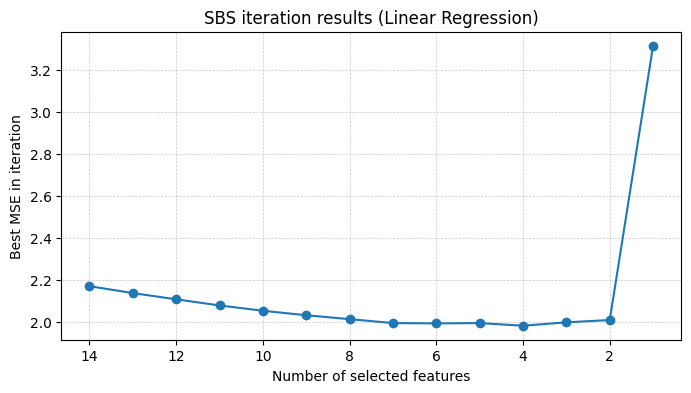

In [9]:
# Plot SBS iteration curve for Task 2.
counts = [entry['selected_count'] for entry in sbs_history]
mse_values = [entry['mse'] for entry in sbs_history]

plt.figure(figsize=(8, 4))
plt.plot(counts, mse_values, marker='o')
plt.xlabel('Number of selected features')
plt.ylabel('Best MSE in iteration')
plt.title('SBS iteration results (Linear Regression)')
plt.gca().invert_xaxis()  # Place higher feature counts on the left for readability.
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


The SBS curve drops quickly when redundant features are removed. It reaches it minimum at 4 retained variables. Beyond that point, MSE rises quickly, showing that stripping additional features starts removing too much information.

## Task 3

Iteration 1: MSE = 4.240
00001000000000: weight_lbs

Iteration 2: MSE = 3.931
00101000000000: displacement	weight_lbs

Iteration 3: MSE = 3.805
00111000000000: displacement	horsepower	weight_lbs

Iteration 4: MSE = 3.766
00111000001000: displacement	horsepower	weight_lbs	more_info_2

Iteration 5: MSE = 3.744
00111001001000: displacement	horsepower	weight_lbs	model_year	more_info_2

Iteration 6: MSE = 3.741
00111011001000: displacement	horsepower	weight_lbs	acceleration	model_year	more_info_2

Iteration 7: MSE = 3.741
01111011001000: cylinders	displacement	horsepower	weight_lbs	acceleration	model_year	more_info_2

Iteration 8: MSE = 3.741
01111011101000: cylinders	displacement	horsepower	weight_lbs	acceleration	model_year	color	more_info_2

Iteration 9: MSE = 3.780
01111011101010: cylinders	displacement	horsepower	weight_lbs	acceleration	model_year	color	more_info_2	more_info_4

Iteration 10: MSE = 3.753
01111111101010: cylinders	displacement	horsepower	weight_lbs	weight_kg	acceleration

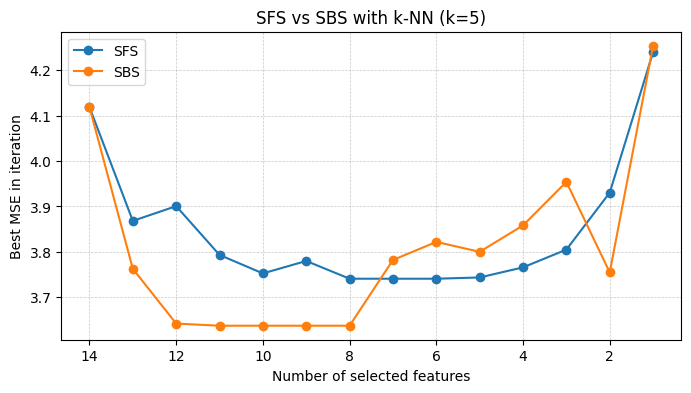

In [10]:
knn_model = KNeighborsRegressor(n_neighbors=5)

knn_sfs_history = SFS(X, y, knn_model, feature_names)
knn_sbs_history = SBS(X, y, knn_model, feature_names)

def summarize_history(history, label):
    best_entry = min(history, key=lambda entry: entry['mse'])
    selected = feature_names[best_entry['mask']]
    selected_list = [str(name) for name in selected]
    feature_line = ', '.join(selected_list) if selected_list else '<none>'
    print(f"Best MSE with k-NN ({label}): {best_entry['mse']:.2f}")
    print(f"R^2 = {best_entry['r2']:.3f}")
    print(f"Selected features: {feature_line}")
    print()
    return best_entry

best_knn_sfs = summarize_history(knn_sfs_history, 'SFS')
best_knn_sbs = summarize_history(knn_sbs_history, 'SBS')

plt.figure(figsize=(8, 4))
for history, label in [(knn_sfs_history, 'SFS'), (knn_sbs_history, 'SBS')]:
    counts = [entry['selected_count'] for entry in history]
    mse_values = [entry['mse'] for entry in history]
    plt.plot(counts, mse_values, marker='o', label=label)

plt.xlabel('Number of selected features')
plt.ylabel('Best MSE in iteration')
plt.title('SFS vs SBS with k-NN (k=5)')
plt.gca().invert_xaxis()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.show()


Best MSE got with k-NN, SFS : 3.74, R^2=0.744

Best MSE got with k-NN, SBS : 3.64, R^2=0.752

Best MSE got with Linear Regression, SFS : 1.98, R^2=0.865

Best MSE got with Linear Regression, SBS : 1.98, R^2=0.865.

Compared with the Task 2 SBS plot, whose error plunged once four variables were retained, the new k-NN figure stays comparatively flat: SBS reaches its minimum only after keeping 11 features, while SFS bottoms out around 6, and both curves remain well above the linear regression baseline. This confirms that k-NN cannot exploit this tabular signal as effectively as the linear model, even though SBS limits damage a bit by preserving a wide feature set.

With k-NN, SFS chose displacement, horsepower, weight_lbs, acceleration, model_year and more_info_2, whereas SBS discarded only weight_lbs, model_year and more_info_3 to get its best score. Linear Regression keeps much leaner subsets: SFS converges on displacement, weight_kg, model_year and more_info_4, while SBS prefers cylinders, weight_kg, model_year and more_info_4. Together, the two plots highlight that Linear Regression achieves its optimum with compact subsets, but k-NN needs many correlated predictors without closing the performance gap.


---
**After the tasks are done, submit this file. Do not clear it's output - all print-outs and diagrams should be left in the file.**